### 케글에서 데이터 직접받아다가 여기서부터 실행함
##############################################

In [1]:
####캐글데이터 다운받아서 풀어놓은 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/data/.kaggle

import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/data/.kaggle"

!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/data/.kaggle
/content/drive/My Drive/Colab Notebooks/data/.kaggle


In [2]:
import tensorflow as tf

In [4]:
import keras
keras.__version__

'2.4.3'

In [5]:
import os, shutil

**훈련된 모델 **

소규모 데이터셋 training 2000개 검증용 1000개

1. 훈련된 작은 모델 cats_and_dogs_small_1.h5
2. 데이터 증식 dropout후 훈련 모델 cats_and_dogs_small_2.h5
3. 사전 훈련된 네트워크로 특성 추출 cats_and_dogs_small_1st.h5

/content/drive/My Drive/Colab Notebooks/data/.kaggle 

내 드라이브에 모델 저장해 놓음

이제 사전 훈련된 모델을 세밀하게 튜닝하기만  하면 됨




**. fit_generator 메서드는 fit 메서드와 동일하되 데이터 제너레이터를 사용할 수 있습니다.**
<= 이 부분은 코드 돌려보니 버젼 업되면서 바뀐 것 같음
fit도 역시 제너레이터가 되는 듯.............
암튼 warning메시지 뜨면서 그냥 fit쓰라고 해서 썼음


fit_generator를 사용할 때 fit 메서드와 마찬가지로 validation_data 매개변수를 전달할 수 있습니다. 이 매개변수에는 데이터 제너레이터도 가능하지만 넘파이 배열의 튜플도 가능합니다. validation_data로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환합니다. 따라서 검증 데이터 제너레이터에서 얼마나 많은 배치를 추출하여 평가할지 validation_steps 매개변수에 지정해야 합니다.

<= **이건 뭔소리인지.....**
검증용 데이터는 증식하는게 아닌 걸로 아는데..
그렇다면 이건 그냥 함수니까 변수 넣어주는 것????

아~~ 번역 좀... 잘했으면 좋았을 뻔...

아마 증식하면 안되는 검증데이터는 test data
위에서 말하는 검증 데이터는 validation data인 듯.. OK!!

네트워크 구성하기

Data Wrangling

# **데이터 증식과 드롭아웃을 사용하여 이 네트워크를 훈련**


데이터 증식을 사용하여 새로운 네트워크를 훈련시킬 때 네트워크에 같은 입력 데이터가 두 번 주입되지 않습니다. 하지만 적은 수의 원본 이미지에서 만들어졌기 때문에 여전히 입력 데이터들 사이에 상호 연관성이 큽니다. 즉, 새로운 정보를 만들어낼 수 없고 단지 기존 정보의 재조합만 가능합니다. 그렇기 때문에 완전히 과대적합을 제거하기에 충분하지 않을 수 있습니다. 과대적합을 더 억제하기 위해 완전 연결 분류기 직전에 Dropout 층을 추가

# **VGG16 이용 전이학습**

* *첫번째 데이터 증식 사용할 수 없는 모델**

첫번째 모델은 너무 빨리 과적합됨.........

# ***2nd***

코랩에서 내 드라이브로 다 올려놓고 GPU로 바꿔서 작업함


In [6]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base.trainable = False


print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30
conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [10]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = './train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = './datasets/cats_and_dogs_small'
#if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
#    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
#os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

In [11]:
from keras import optimizers

In [12]:

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [14]:

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
100/100 - 777s - loss: 0.5293 - acc: 0.7450 - val_loss: 0.4129 - val_acc: 0.8500
Epoch 2/30
100/100 - 21s - loss: 0.4052 - acc: 0.8240 - val_loss: 0.3458 - val_acc: 0.8670
Epoch 3/30
100/100 - 21s - loss: 0.3464 - acc: 0.8585 - val_loss: 0.3150 - val_acc: 0.8730
Epoch 4/30
100/100 - 21s - loss: 0.3226 - acc: 0.8640 - val_loss: 0.2889 - val_acc: 0.8800
Epoch 5/30
100/100 - 21s - loss: 0.3019 - acc: 0.8740 - val_loss: 0.2705 - val_acc: 0.8930
Epoch 6/30
100/100 - 21s - loss: 0.2842 - acc: 0.8830 - val_loss: 0.2692 - val_acc: 0.8980
Epoch 7/30
100/100 - 21s - loss: 0.2856 - acc: 0.8845 - val_loss: 0.2597 - val_acc: 0.8990
Epoch 8/30
100/100 - 21s - loss: 0.2689 - acc: 0.8820 - val_loss: 0.2529 - val_acc: 0.8990
Epoch 9/30
100/100 - 21s - loss: 0.2568 - acc: 0.9005 - val_loss: 0.2500 - val_acc: 0.9030
Epoch 10/30
100/100 - 21s - loss: 0.2501 - acc: 0.8975 - val_loss: 0.2467 - val_acc: 0.9030
Epoch 11/30
100/100 - 21s - loss: 0.2412 - acc: 0.9100 - val_loss: 0.2491 - val_acc: 0.9

In [15]:
model.save('cats_and_dogs_small_2nd.h5')

In [17]:
import matplotlib.pyplot as plt

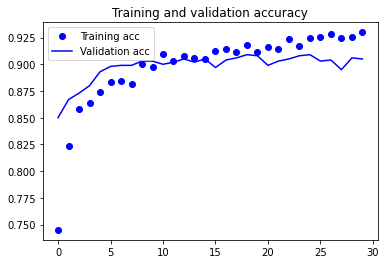

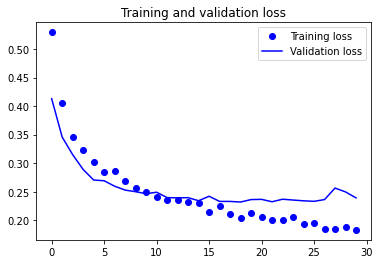

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **미세조정 **

기반 네트워크에서 일부 층의 동경을 해제

 동결을 해제한 층과 추가한 층을 함께 훈련

In [19]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [21]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 23s 226ms/step - loss: 0.2047 - acc: 0.9180 - val_loss: 0.2309 - val_acc: 0.9110
Epoch 2/100
100/100 [==============================] - 23s 227ms/step - loss: 0.1571 - acc: 0.9375 - val_loss: 0.2258 - val_acc: 0.9140
Epoch 3/100
100/100 [==============================] - 22s 224ms/step - loss: 0.1373 - acc: 0.9445 - val_loss: 0.2114 - val_acc: 0.9140
Epoch 4/100
100/100 [==============================] - 22s 223ms/step - loss: 0.1131 - acc: 0.9510 - val_loss: 0.2695 - val_acc: 0.9020
Epoch 5/100
100/100 [==============================] - 23s 229ms/step - loss: 0.0963 - acc: 0.9645 - val_loss: 0.2347 - val_acc: 0.9200
Epoch 6/100
100/100 [==============================] - 22s 222ms/step - loss: 0.0854 - acc: 0.9680 - val_loss: 0.2475 - val_acc: 0.9110
Epoch 7/100
100/100 [==============================] - 22s 219ms/step - loss: 0.0904 - acc: 0.9665 - val_loss: 0.2067 - val_acc: 0.9310
Epoch 8/100
100/100 [===========================

In [22]:
model.save('cats_and_dogs_small_3rd.h5')

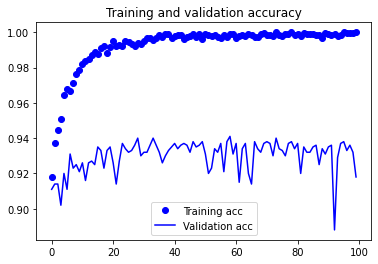

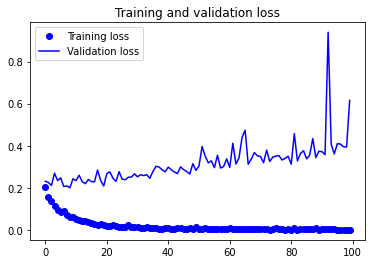

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

불규칙한 그래프를 보기 쉽게 하기 위해 지수 이동 평균으로 정확도와 손실 값을 부드럽게 표현

**지수 이동 평균을 위한 간단 함수**

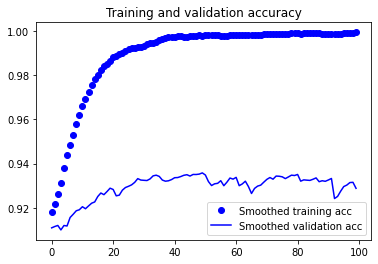

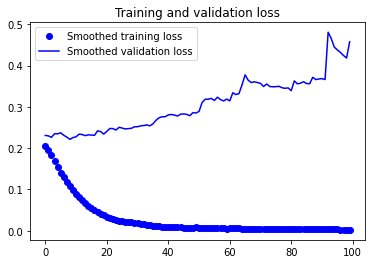

In [24]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

손실 곡선은 실제 어떤 향상을 얻지 못했습니다(사실 악화되었습니다). 손실히 감소되지 않았는데 어떻게 정확도가 안정되거나 향상될 수 있을까요? 답은 간단합니다. 그래프는 개별적인 손실 값의 평균을 그린 것입니다. 하지만 정확도에 영향을 미치는 것은 

**손실 값의 분포이지 평균이 아닙니다.**

 정확도는 모델이 예측한 클래스 확률이 어떤 임계값을 넘었는지에 대한 결과이기 때문입니다. 모델이 더 향상더라도 평균 손실에 반영되지 않을 수 있습니다.

In [26]:
### 모델 평가

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 106s 2s/step - loss: 0.6838 - acc: 0.9240
test acc: 0.9240000247955322
